# F1 data analysis notebook 
#### @kevinofsydney

Notes:
- The 'KeyError' is because the name of the column gets consumed when it is turned into an index 
- df.describe() is useful
- oddsportal.com
- race_df['name'].unique()
- http://www.f1-predictor.com/category/data-science/
- https://www.f1hotornot.com/ - this is a very good form rating, and could be used to also indicate whether a driver is expected to overperform or underperform their average

"How should we apply cross-validation to data that are time-ordered (like F1 results)? The basic idea remains the same but instead of splitting the training data into 3 random folds, we break it in a way that the validation data always refer to a later period compared to the training data.

"Here’s how your CV would work: you train the model on the first 20 races and you make predictions for the next 10 ones. You calculate the relevant metrics. Then, you train the model on the first 30 races (or the races 11-30, this is a choice you have to take) and predict on the next 10. You keep doing this for the next 2 folds. Finally, you calculate the average performance."


### To do list
- Automate adding the column labels
- Calculate the average race result for each driver
- Create a working prototype to predict qualifier results
- Create a working prototype to predict race results

In [58]:
import pandas as pd
import numpy as np
%matplotlib inline

## Preprocessing

In [59]:
# Load the files
cir_df = pd.read_csv('circuits_l.csv')
conresult_df = pd.read_csv('constructor_results_l.csv')
constanding_df = pd.read_csv('constructor_standings_l.csv')
con_df = pd.read_csv('constructors_l.csv')
driver_df = pd.read_csv('driver_l.csv')
laptime_df = pd.read_csv('lap_times_l.csv')
quali_df = pd.read_csv('qualifying_l.csv')
race_df = pd.read_csv('races_l.csv')
result_df = pd.read_csv('results_l.csv')
status_df = pd.read_csv('status_l.csv')

# Set the correct indices 
race_df['date'] = pd.to_datetime(race_df['date'], dayfirst=True)

# driver_df.set_index('driverId', inplace=True)
quali_df.set_index('qualifyId', inplace=True)
laptime_df.set_index('raceId', inplace=True)
race_df.set_index('date', inplace=True)
result_df.set_index('resultId', inplace=True)

# race_df.sort_values('raceId', inplace=True)
race_df.sort_index(inplace=True)

# Remove unnecessary columns, or columns I still need to implement processing for
result_df = result_df.drop('number', axis=1)

resultsm_df = result_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']]

def label_points(row):
    if row['positionOrder'] <= 3:
        return 1 #'top3'
    elif row['positionOrder'] > 3 and row['positionOrder'] <= 6:
        return 2 # 'top6'
    elif row['positionOrder'] > 6 and row['positionOrder'] <= 10:
        return 3 #'top10'
    else:
        return 4 #'no_points'

resultsm_df = resultsm_df.merge(race_df[['raceId', 'circuitId']], how='left', on=['raceId'])
resultsm_df['raceresult'] = resultsm_df.apply(label_points, axis=1)
resultsm_df.head(5)

,raceId,driverId,constructorId,grid,positionOrder,circuitId,raceresult
0,900,3,131,3,1,1,1
1,900,825,1,4,2,1,1
2,900,18,1,10,3,1,1
3,900,4,6,5,4,1,2
4,900,822,3,15,5,1,2


In [78]:
# Converting the constructors to strings, and then applying OHE. 
# Converting constructor names to strings allows for the columns to be named informatively

def name_constructors(row):
    if row['constructorId'] == 1:
        return 'MCL'
    elif row['constructorId'] == 3:
        return 'WIL'
    elif row['constructorId'] == 4:
        return 'REN'
    elif row['constructorId'] == 5:
        return 'TOR'
    elif row['constructorId'] == 6:
        return 'FER'
    elif row['constructorId'] == 9:
        return 'RBR'
    elif row['constructorId'] == 10:
        return 'RCP'
    elif row['constructorId'] == 15:
        return 'SAU'
    elif row['constructorId'] == 51:
        return 'ALF'
    elif row['constructorId'] == 131:
        return 'MER'
    elif row['constructorId'] == 206:
        return 'RUS'
    elif row['constructorId'] == 207:
        return 'CAT'
    elif row['constructorId'] == 208:
        return 'LOT'
    elif row['constructorId'] == 209:
        return 'MAN'
    elif row['constructorId'] == 210:
        return 'HAA'
    elif row['constructorId'] == 211:
        return 'RCP'
    
# Converting the constructors to Categorical data type
resultsm_df['cstrIdString'] = resultsm_df.apply(name_constructors, axis=1)
resultsm_df['cstrIdString'] = pd.Categorical(resultsm_df['cstrIdString'])

# Geting the dummies of the categories
cstrStringDummies = pd.get_dummies(resultsm_df['cstrIdString'], prefix='cstr')
cstrStringDummies.head(10)

# Add the dummy columns back into the main results df 
resultsmx_df = pd.merge(resultsm_df, cstrStringDummies, left_index=True, right_index=True)

# Save the constructorIdStrings to put back in after predictions
cstrIdStrings = resultsm_df[['cstrIdString']]

# Drop the original columns from the testing data so that only the OHE form of the cstr remains
if 'constructorId' in resultsmx_df.columns:
    resultsmx_df = resultsmx_df.drop(columns=['constructorId'])

if 'constructorIdString' in resultsmx_df.columns: 
    resultsmx_df = resultsmx_df.drop(columns=['constructorIdString'])

## Modelling

In [4]:
# Splitting into training and test sets
# data - resultsm_df[['circuitId', 'driverId', 'constructorId', 'grid']]
# target - resultsm_df[['raceresult']]

from sklearn.model_selection import train_test_split

# Driver-OHE version
data_train, data_test, label_train, label_test = train_test_split(resultsmx_df.drop(columns=['raceresult']),
                                                                  resultsmx_df[['raceresult']],
                                                                  test_size=0.25, 
                                                                  random_state=1)

# data_train.describe()
# data_test.describe()
# label_train.describe()
label_test.describe()

,raceresult
count,577.000000
mean,3.079723
std,1.124485
min,1.000000
25%,2.000000
50%,4.000000
75%,4.000000
max,4.000000


In [26]:
# SVM
# Accuracy before OHE: 0.6308

from sklearn import svm
clf_svm = svm.SVC(kernel='linear', C=1).fit(data_train, np.ravel(label_train))
print("SVM accuracy:", clf_svm.score(data_test, label_test))

SVM accuracy: 1.0


In [80]:
# Naive-Bayes
# Accuracy before OHE: 0.6066

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
clf_nb = gnb.fit(data_train, np.ravel(label_train))
pred = clf_nb.predict(data_test)

# Print the accuracy score of the model
print("Naive-Bayes accuracy: ", accuracy_score(label_test, pred, normalize = True))

pred = pd.DataFrame(data=pred, columns=['nb_preds'])

nb_result = pd.merge(pd.merge(data_test[['raceId', 'driverId', 'grid', 'positionOrder', 'circuitId']], 
                     cstrIdStrings, left_index=True, right_index=True), f, left_index=True, right_index=True)

nb_result

Naive-Bayes accuracy:  0.7660311958405546


,raceId,driverId,grid,positionOrder,circuitId,cstrIdString,preds
111,905,1,2,2,6,MER,4
195,908,821,19,20,9,SAU,4
485,930,3,1,1,4,MER,4
464,928,807,16,20,17,RCP,4
47,902,817,13,4,3,RBR,4
...,...,...,...,...,...,...,...
125,905,822,13,16,6,WIL,4
220,910,817,4,1,11,RBR,4
452,928,831,9,8,17,SAU,1
149,906,155,21,18,7,CAT,4


## Code Graveyard

In [7]:
# Find a driverId via their code
code = 'RAI'
did = driver_df[ driver_df['code'] == code]['driverId']
print("INFO: driverID for", code, "is:", int(did))

### Return the result for a single driver
resultsm_df[resultsm_df['driverId'] == int(did)].head(20)

resultsm_df['driverId'].nunique()

INFO: driverID for RAI is: 8


45

In [8]:
# Merging the quali, driver_details and results dataframes together
quali_rdf = quali_df[['raceId', 'driverId', 'q1', 'q2', 'q3']]
master = driver_df[['driverId', 'code']].merge(quali_rdf, how='inner', on=['driverId'])
master = master.merge(result_df, how='inner', left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'])
# master.sort_values(by=['raceId', 'positionOrder']).head(50)
master.head(5)
# Train the model

,driverId,code,raceId,q1,q2,q3,constructorId,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,HAM,900,01:31.7,01:42.9,01:44.2,131,1,\N,R,19,0,2,\N,\N,2,20,01:49.9,173.636,5
1,1,HAM,901,01:57.2,01:59.0,01:59.4,131,1,1,1,1,25,56,40:26.0,6025974,53,1,01:43.1,193.611,1
2,1,HAM,902,01:35.3,01:33.9,01:33.5,131,2,1,1,1,25,57,39:42.7,5982743,49,2,01:37.1,200.634,1
3,1,HAM,903,01:55.5,01:54.0,01:53.9,131,1,1,1,1,25,54,33:28.3,5608338,42,2,01:41.2,193.916,1
4,1,HAM,904,01:27.2,01:26.2,01:25.2,131,1,1,1,1,25,66,41:05.2,6065155,54,3,01:29.5,187.275,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad1cdbdc90>,
      dtype=object)

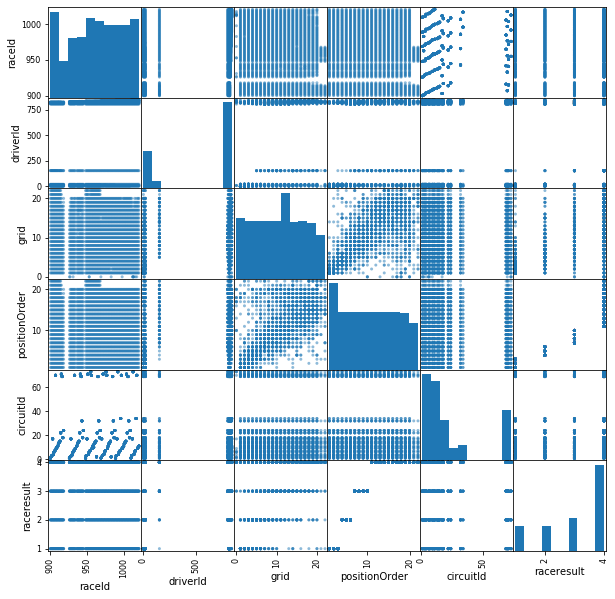

In [9]:
# Replace raceId with circuitId
from pandas.plotting import scatter_matrix
scatter_matrix(resultsm_df[['raceId','driverId','constructorId','grid','positionOrder','circuitId', 'raceresult']], figsize=(10,10))